# Анализ пользователей оператора сотовой связи

<br>

В проекте представлена информация о пользователях федерального оператора сотовой связи. Данные представлены для двух тарифных планов «Смарт» и «Ультра» по 500 пользователям за 2018 год с информацией по звонкам, сообщениям и интернет-сессиям. <br>
<br>
<b>Задачи проекта:</b> <br>
- проанализировать поведение клиентов при использовании данных тарифных планов <br>
- проверить несколько гипотез о различии выручки и длительности звонков абонентов разных тарифных планов и регионов<br>

<b>Содержание проекта:</b><br>
1. Предобработка<br>
2. Анализ данных<br>
3. Проверка гипотез<br>
4. Общий вывод<br>

### Предобработка

In [1]:
# импорт необходимых библиотек
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

<b>Описание датасета:</b> <br>
В проекте использованы 5 датасетов с информацией за период 2018 год:<br>
- звонки<br>
- интернет-сессии<br>
- отправленные сообщения<br>
- тарифы<br>
- абоненты<br>

In [2]:
# получение данных
calls = pd.read_csv('calls.csv')
sessions = pd.read_csv('sessions.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')
display(calls.head(1))
display(sessions.head(1))
display(messages.head(1))
display(tariffs.head())
display(users.head(1))
#calls.info()
#sessions.info()
#messages.info()
#tariffs.info()
#users.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [3]:
# удаляем из файла пользователей персональную информацию (ФИО)
users = users.drop(columns = ['first_name','last_name'])

In [4]:
# приведение дат к формату datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [5]:
# перевод длительности звонков в целые числа с округлением вверх
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [6]:
# проверим период данных для анализа - нет ли выбросов за другие годы
print('Звонки - минимальная и максимальная дата:', calls['call_date'].min(), calls['call_date'].max() )
print('Интернет-сессии - минимальная и максимальная дата:', sessions['session_date'].min(),sessions['session_date'].max())
print('Сообщения - минимальная и максимальная дата:', messages['message_date'].min(),messages['message_date'].max())

Звонки - минимальная и максимальная дата: 2018-01-01 00:00:00 2018-12-31 00:00:00
Интернет-сессии - минимальная и максимальная дата: 2018-01-01 00:00:00 2018-12-31 00:00:00
Сообщения - минимальная и максимальная дата: 2018-01-02 00:00:00 2018-12-31 00:00:00


In [7]:
# создание столбцов 'месяц'
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

### Анализ данных

<b>/ Агрегация данных </b>

In [8]:
# группировка данных по месяцам
calls_per_month = calls.groupby(['user_id','month']).agg(calls=('duration', 'count'))
display(calls_per_month.head(1))
minutes_per_month = calls.groupby(['user_id','month']).agg(minutes=('duration', 'sum'))
display(minutes_per_month.head(1))
sessions_per_month = sessions.groupby(['user_id','month']).agg({'mb_used': 'sum'})
display(sessions_per_month.head(1))
messages_per_month = messages.groupby(['user_id','month']).agg(messages=('message_date', 'count'))
display(messages_per_month.head(1))

,,calls
user_id,month,
1000,5,22


,,minutes
user_id,month,
1000,5,159


,,mb_used
user_id,month,
1000,5,2253.49


,,messages
user_id,month,
1000,5,22


In [9]:
# создание таблицы со всеми данными по месяцам
user_behavior = calls_per_month.merge(
    messages_per_month, left_index=True, right_index=True, how='outer'
    ).merge(
    sessions_per_month, left_index=True, right_index=True, how='outer'
    ).merge(
    minutes_per_month, left_index=True, right_index=True, how='outer'
    ).reset_index().merge(
    users, how='left', left_on='user_id', right_on='user_id'
    )
# заменим пропуски на нули
user_behavior = user_behavior.fillna(0)
# добавим данные по тарифам
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
user_behavior = user_behavior.merge(tariffs, on='tariff')
# проверка корректности объединения
display(user_behavior.head(1))

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,22.0,2253.49,159.0,52,0,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [10]:
# рассчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']
# где нет превышения добавим нули
for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0
# переводим мегабайты превышения в гигабайты с  округлением вверх
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)
# добавим расчетные столбцы с суммой переплаты
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']
# считаем выручку на пользователя из стоимости оптаты тарифа + переплата
user_behavior['total_cost'] = user_behavior['rub_monthly_fee'] + user_behavior['cost_minutes'] + user_behavior['cost_messages']  + user_behavior['cost_gb']
display(user_behavior.head(3))

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb,cost_minutes,cost_messages,cost_gb,total_cost
0,1000,5,22.0,22.0,2253.49,159.0,52,0,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
1,1000,6,43.0,60.0,23233.77,172.0,52,0,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
2,1000,7,47.0,75.0,14003.64,340.0,52,0,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0


In [11]:
# сохранение статистических метрик для пары месяц-тариф (среднее значение, стандартное отклонение, медиана)
stats_by_month = user_behavior.pivot_table(
            index=['month', 'tariff'],
            values=['calls', 'minutes', 'messages', 'mb_used'],
            aggfunc=['mean', 'std', 'median']
    ).round(2).reset_index()
stats_by_month.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']
display(stats_by_month.head(3))

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0


In [12]:
# нахождение средних значений по году для каждого пользователя
user_behavior_total = user_behavior.pivot_table(
            index=['user_id','tariff'],
            values=['calls', 'minutes', 'messages', 'mb_used'],
            aggfunc=['mean']
    ).round(2).reset_index()
user_behavior_total.columns=['user_id','tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean']
display(user_behavior_total.head(3))

,user_id,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean
0,1000,ultra,46.0,13424.04,62.0,320.75
1,1001,smart,61.0,16233.00,0.0,422.00
2,1002,smart,31.0,16576.65,10.0,216.71


<b>/ Визуализация агрегированных данных </b>

<b>/ Кол-во звонков</b>

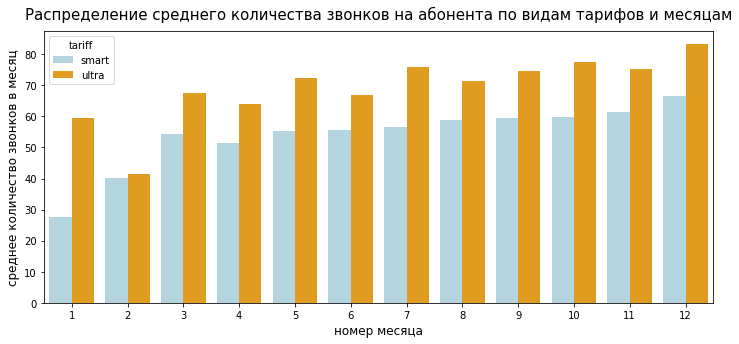

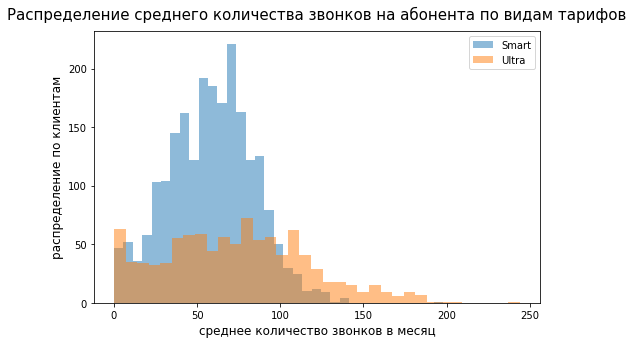

Среднее по году:
Smart: 58.65
Ultra: 73.44


In [13]:
# распределение среднего количества звонков по тарифам по месяцам
plt.figure(figsize=(12, 5))
sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_by_month,
            palette=['lightblue', 'orange'])
plt.title('Распределение среднего количества звонков на абонента по видам тарифов и месяцам', size = 15, y= 1.02)
plt.xlabel('номер месяца', size = 12)
plt.ylabel('среднее количество звонков в месяц', size = 12)
plt.show()
# гистограмма распределения
plt.figure(figsize=(8, 5))
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.title('Распределение среднего количества звонков на абонента по видам тарифов', size = 15, y= 1.02)
plt.xlabel('среднее количество звонков в месяц', size = 12)
plt.ylabel('распределение по клиентам', size = 12)
plt.show()
# распределение среднего количества звонков по тарифам по году
print('Среднее по году:')
print('Smart:',round(user_behavior_total[user_behavior_total['tariff'] == 'smart']['calls_mean'].mean(),2))
print('Ultra:',round(user_behavior_total[user_behavior_total['tariff'] == 'ultra']['calls_mean'].mean(),2))

<b> Выводы:</b> <br>
Среднее кол-во звонков у абонентов тарифа «Ультра» больше, чем у абонентов тарифа «Смарт». В течение года пользователи обоих тарифов незначительно увеличивают кол-во звонков в месяц. 

<b>/ Длительность звонков</b>

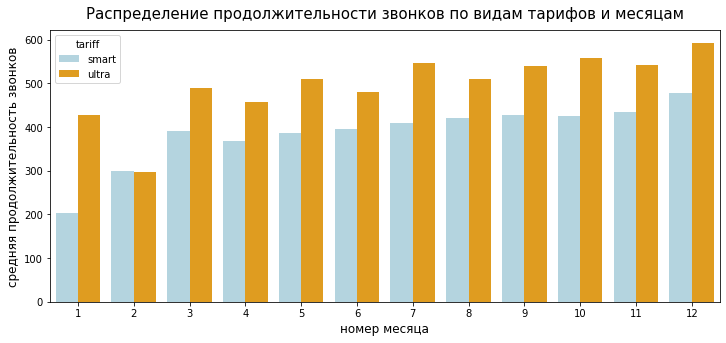

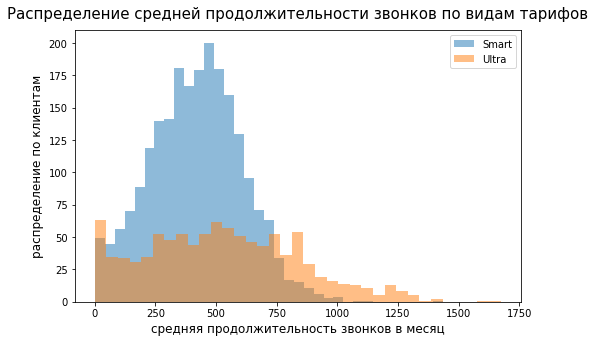

Среднее по году:
Smart: 419.63
Ultra: 527.82


In [14]:
# распределение средней продолжительности звонков по тарифам и месяцам
plt.figure(figsize=(12, 5))
sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_by_month,
            palette=['lightblue', 'orange'])
plt.title('Распределение продолжительности звонков по видам тарифов и месяцам', size = 15, y= 1.02)
plt.xlabel('номер месяца', size = 12)
plt.ylabel('средняя продолжительность звонков', size = 12)
plt.show()
# гистограмма распределения
plt.figure(figsize=(8, 5))
user_behavior.groupby('tariff')['minutes'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.title('Распределение средней продолжительности звонков по видам тарифов', size = 15, y= 1.02)
plt.xlabel('средняя продолжительность звонков в месяц', size = 12)
plt.ylabel('распределение по клиентам', size = 12)
plt.show()
# распределение средней продолжительности звонков по тарифам по году
print('Среднее по году:')
print('Smart:',round(user_behavior_total[user_behavior_total['tariff'] == 'smart']['minutes_mean'].mean(),2))
print('Ultra:',round(user_behavior_total[user_behavior_total['tariff'] == 'ultra']['minutes_mean'].mean(),2))

<b> Выводы:</b> <br>
Средняя длительность разговоров у абонентов тарифа «Ультра» больше, чем у абонентов тарифа «Смарт». В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. 

<b>/ Кол-во сообщений </b>

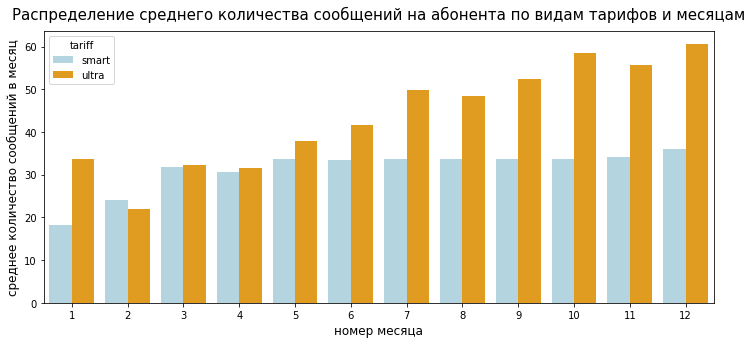

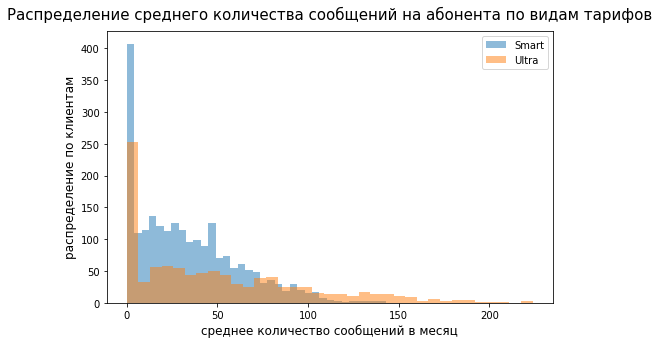

Среднее по году:
Smart: 32.35
Ultra: 54.03


In [15]:
# распределение среднего количества сообщений по тарифам по месяцам
plt.figure(figsize=(12, 5))
sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_by_month,
            palette=['lightblue', 'orange'])
plt.title('Распределение среднего количества сообщений на абонента по видам тарифов и месяцам', size = 15, y= 1.02)
plt.xlabel('номер месяца', size = 12)
plt.ylabel('среднее количество сообщений в месяц', size = 12)
plt.show()
# гистограмма распределения
plt.figure(figsize=(8, 5))
user_behavior.groupby('tariff')['messages'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.title('Распределение среднего количества сообщений на абонента по видам тарифов', size = 15, y= 1.02)
plt.xlabel('среднее количество сообщений в месяц', size = 12)
plt.ylabel('распределение по клиентам', size = 12)
plt.show()
# распределение среднего количества сообщений по тарифам по году
print('Среднее по году:')
print('Smart:',round(user_behavior_total[user_behavior_total['tariff'] == 'smart']['messages_mean'].mean(),2))
print('Ultra:',round(user_behavior_total[user_behavior_total['tariff'] == 'ultra']['messages_mean'].mean(),2))

<b> Выводы:</b> <br>
Пользователи тарифа «Ультра» отправляют в среднем почти на 20 сообщений больше, чем пользователи тарифа «Смарт». Количество сообщений в течение года на обоих тарифак растет.

<b>/ Кол-во мегабайт </b>

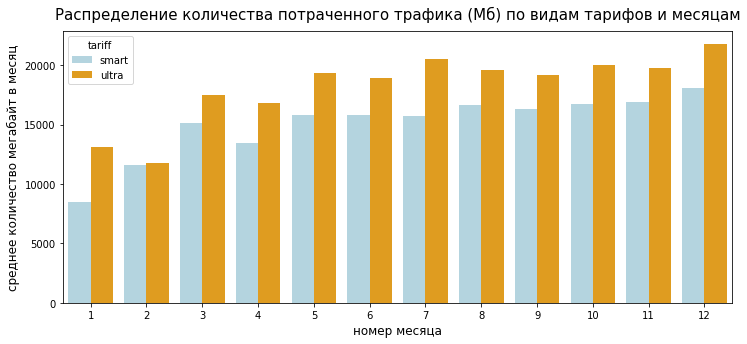

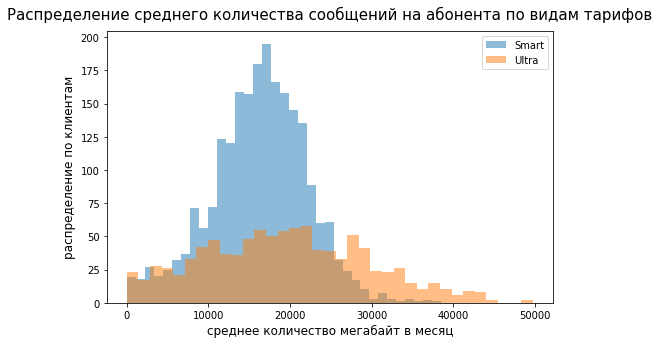

Среднее по году:
Smart: 16180.61
Ultra: 19574.64


In [16]:
# распределение среднего количества мегабайт по тарифам по месяцам
plt.figure(figsize=(12, 5))
sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_by_month,
            palette=['lightblue', 'orange'])
plt.title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам', size = 15, y= 1.02)
plt.xlabel('номер месяца', size = 12)
plt.ylabel('среднее количество мегабайт в месяц', size = 12)
plt.show()
# гистограмма распределения
plt.figure(figsize=(8, 5))
user_behavior.groupby('tariff')['mb_used'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.title('Распределение среднего количества сообщений на абонента по видам тарифов', size = 15, y= 1.02)
plt.xlabel('среднее количество мегабайт в месяц', size = 12)
plt.ylabel('распределение по клиентам', size = 12)
plt.show()
# распределение среднего количества мегабайт по тарифам по году
print('Среднее по году:')
print('Smart:',round(user_behavior_total[user_behavior_total['tariff'] == 'smart']['sessions_mean'].mean(),2))
print('Ultra:',round(user_behavior_total[user_behavior_total['tariff'] == 'ultra']['sessions_mean'].mean(),2))

<b> Выводы:</b> <br>
Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа «Смарт» тратят 15-17 Гб, а абоненты тарифного плана «Ультра» - 19-21 ГБ.

### Проверка гипотез

<b> Гипотеза №1: </b> средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются <br>
<br>
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"<br>
H_1: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"<br>
<br>
Уровень статистической значимости alpha = 0.05<br>
<br>
Результат нахождения p-значения:<br>
-p-value > значения alpha => нулевая гипотеза верна, выручка по тарифам "Смарт" и "Ультра" одинаковая <br>
-p-value < значения alpha => нулевую гипотезу отвергаем, выручка пользователей тарифов "Смарт" и "Ультра" отличается

In [17]:
# вызов метода для проверки гипотезы
results = st.ttest_ind((user_behavior[user_behavior['tariff'] == 'smart']['total_cost']),(user_behavior[user_behavior['tariff'] == 'ultra']['total_cost']),equal_var=False)
alpha = 0.05   
print('p-значение: ', round(results.pvalue,5))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


<b> Выводы по оценке гипотезы №1: </b><br>
Гипотеза Н0 не верна: выручка пользователей тарифов "Смарт" и "Ультра" отличается с вероятной долей ошибки в 5%.

<b> Гипотеза №2: </b> пользователи из Москвы приносят больше выручки, чем пользователи из других городов<br>
<br>
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы<br>
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы<br>
<br>
Уровень статистической значимости alpha = 0.05<br>
<br>
Результат нахождения p-значения:<br>
-p-value > значения alpha => нулевая гипотеза верна, пользователи из Москвы и регионов приносят одинаковую выручку <br>
-p-value < значения alpha => нулевую гипотезу отвергаем, выручка пользователей из Москвы и не из Москвы разная

In [18]:
# вызов метода для проверки гипотезы
results = st.ttest_ind((user_behavior[user_behavior['city'] == 'Москва']['total_cost']),(user_behavior[user_behavior['city'] != 'Москва']['total_cost']),equal_var=False)
alpha = 0.05 
print('p-значение: ', round(results.pvalue,5))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.52574
Не получилось отвергнуть нулевую гипотезу


<b> Выводы по гипотезе №2: </b><br>
Гипотеза Н0 верна: пользователи из Москвы и регионов приносят одинаковую выручку с вероятной долей ошибки в 5%.

<b> Гипотеза №3: </b> пользователи из Москвы и не из Москвы имеют разную продолжительность разговоров <br>
<br>
H_0: Среднее время разговора (minutes) пользователей из Москвы = среднее время разговора (minutes) пользователей не из Москвы<br>
H_1: Среднее время разговора (minutes) пользователей из Москвы ≠ среднее время разговора (minutes) пользователей не из Москвы<br>
<br>
Уровень статистической значимости alpha = 0.05<br>
<br>
Результат нахождения p-значения:<br>
-p-value > значения alpha => нулевая гипотеза верна, пользователи из Москвы и не из Москвы имеют одинаковую продолжительность звонков <br>
-p-value < значения alpha => нулевую гипотезу отвергаем, пользователи из Москвы и не из Москвы имеют разную продолжительность звонков 

In [19]:
# вызов метода для проверки гипотезы
results = st.ttest_ind((user_behavior[user_behavior['city'] == 'Москва']['minutes']),(user_behavior[user_behavior['city'] != 'Москва']['minutes']),equal_var=False)
alpha = 0.05 
print('p-значение: ', round(results.pvalue,5))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.04207
Отвергаем нулевую гипотезу


<b> Выводы по гипотезе №3: </b><br>
Гипотеза Н0 не верна: пользователи из Москвы и не из Москвы имеют разную продолжительность звонков с вероятной долей ошибки в 5%.

### Общий вывод

В рамках проекта по анализу данных пользователей оператора сотовой связи была проведена следующая работа: <br>
1. Проведена предобработка датасета на предмет форматов данных, добавлены дополнительные столбцы. <br>
 <br>
2. Проведена агрегация данных по месяцам и подготовлена визуализация результатов пользования 2-х тарифных планов. <br>
Краткие выводы:<br>
- среднее кол-во звонков у абонентов тарифа «Ультра» больше, чем у абонентов тарифа «Смарт», в течение года пользователи обоих тарифов незначительно увеличивают кол-во звонков в месяц; <br>
- средняя длительность разговоров у абонентов тарифа «Ультра» больше, чем у абонентов тарифа «Смарт», в течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров;<br>
- пользователи тарифа «Ультра» отправляют в среднем почти на 20 сообщений больше, чем пользователи тарифа «Смарт», количество сообщений в течение года на обоих тарифак растет;
- чаще всего абоненты тарифа «Смарт» тратят 15-17 Гб, а абоненты тарифного плана «Ультра» - 19-21 ГБ.
<br>
3. Проведен анализ трех гипотез о различии выручки и длительности звонков абонентов разных тарифных планов и регионов <br>
Краткие выводы:<br>
- Гипотеза №1 не верна: выручка пользователей тарифов "Смарт" и "Ультра" отличается с вероятной долей ошибки в 5%;<br>
- Гипотеза №2 верна: пользователи из Москвы и регионов приносят одинаковую выручку с вероятной долей ошибки в 5%<br>
- Гипотеза №3 не верна: пользователи из Москвы и не из Москвы имеют разную продолжительность звонков с вероятной долей ошибки в 5%.